This is a simple example showing how to use this package to train a machine learning force field using your data.

In this example, we will study a system of two helium atoms interacting through a Lennard-Jones potential. The example is divided into two main sections:

1) Model Setup and Training:
    We will load a pre-generated dataset containing configurations of two helium atoms in a simulation box and use the SymmLearn functions to build and train our neural network model.

2) Results and Comparison:
    Finally, we will analyze the results. For this simple case, it is possible to visualize the trained force field and compare it to the reference Lennard-Jones potential.


In [52]:
#using Symmlearn
using Plots

include("../src/MLTrain.jl")
include("../src/Data_prep.jl")
include("../src/Utils.jl")

fc (generic function with 1 method)

The loading process of the .xyz dataset con be done as illustrated here in the next code block.

This dataset consists in 500 samples,for each of them the energy was computed using a Lennard-Jones potential with $\sigma$ = 1 and $\epsilon$ = 1.

For each sample the distance between the two Helium atoms was randomly generated between 0.95 $\sigma$ and 2.5 $\sigma$


In [41]:
file_path = "helium_LJ_dataset.xyz"

Train, Val, Test_data, energy_mean, energy_std, forces_mean, forces_std, species, all_cells = xyz_to_nn_input(file_path)



((Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Dict{Symbol, Any}[Dict(:energy => 0.35883918f0, :forces => Float32[0.016720707, -0.016720707, 0.0, 0.0, 0.0, 0.0]), Dict(:energy => 0.40782464f0, :forces => Float32[0.0074224523, -0.0074224523, 0.0, 0.0, 0.0, 0.0]), Dict(:energy => 0.10743303f0, :forces => Float32[0.072323024, -0.072323024, 0.0, 0.0, 0.0, 0.0]), Dict(:energy => -0.45375478f0, :forces => Float32[0.20613274, -0.20613274, 0.0, 0.0, 0.0, 0.0]), Dict(:energy => -1.9894472f0, :forces => Float32[-0.10993084, 0.10993084, 0.0, 0.0, 0.0, 0.0]), Dict(:energy => 0.11288355f0, :forces => Float32[0.07104557, -0.07104557, 0.0, 0.0, 0.0, 0.0]), Dict(:energy => -1.8430845f0, :forces => Float32[-0.5357527, 0.5357527, 0.0, 0.0, 0.0, 0.0]), Dict(:energy => -1.086527f0, :forces => Float32[0.3326668, -0.3326668, 0.0, 0.0, 0.0, 0.0]), Dict(:energy => -0.43856966f0, :forces => Float32[0.20260504, -0.20260504, 0.0, 0.0, 0.0, 0.0]), Dict(:energy => -1.848

In [51]:
println(Train)

(Float32[0.0 0.0 0.0 2.154038 0.0 0.0; 0.0 0.0 0.0 2.42253 0.0 0.0; 0.0 0.0 0.0 1.733364 0.0 0.0; 0.0 0.0 0.0 1.459812 0.0 0.0; 0.0 0.0 0.0 1.111155 0.0 0.0; 0.0 0.0 0.0 1.738101 0.0 0.0; 0.0 0.0 0.0 1.081187 0.0 0.0; 0.0 0.0 0.0 1.312994 0.0 0.0; 0.0 0.0 0.0 1.464441 0.0 0.0; 0.0 0.0 0.0 1.081764 0.0 0.0; 0.0 0.0 0.0 2.126052 0.0 0.0; 0.0 0.0 0.0 1.593364 0.0 0.0; 0.0 0.0 0.0 2.360202 0.0 0.0; 0.0 0.0 0.0 2.414752 0.0 0.0; 0.0 0.0 0.0 1.835863 0.0 0.0; 0.0 0.0 0.0 1.732177 0.0 0.0; 0.0 0.0 0.0 1.530998 0.0 0.0; 0.0 0.0 0.0 2.439482 0.0 0.0; 0.0 0.0 0.0 1.920724 0.0 0.0; 0.0 0.0 0.0 1.858264 0.0 0.0; 0.0 0.0 0.0 1.525875 0.0 0.0; 0.0 0.0 0.0 2.052758 0.0 0.0; 0.0 0.0 0.0 1.029059 0.0 0.0; 0.0 0.0 0.0 1.01855 0.0 0.0; 0.0 0.0 0.0 1.984942 0.0 0.0; 0.0 0.0 0.0 0.982478 0.0 0.0; 0.0 0.0 0.0 2.170731 0.0 0.0; 0.0 0.0 0.0 2.344867 0.0 0.0; 0.0 0.0 0.0 2.198818 0.0 0.0; 0.0 0.0 0.0 1.423382 0.0 0.0; 0.0 0.0 0.0 1.969196 0.0 0.0; 0.0 0.0 0.0 1.031569 0.0 0.0; 0.0 0.0 0.0 1.09622 0.0 0.0; 0.0 

The xyz_to_nn_input function returns the data already split in test, train and validation, the mean and the standard deviation of both the energies and the forces in order to renormalize them later and the lattice parameters, used by the model to compute the atomic distances with periodic boundary conditions ( in this example we won't be using PBC as the helium atoms are confined in a box )

In the next block we wil building and training our model,  since the system is trivial using the forces to train it won't be needed

In [ ]:
#define the model using 10 G1 symmetry functions

model = build_model(species, 5, 2.5f0)

#train the model

last_model,trained_model,train_loss,val_loss = train_model!(
        model,
        Train[1], 
        Train[2], 
        Val[1],
        Val[2],
        loss_function_no_forces;
         initial_lr=0.1,epochs=1, batch_size=16 , verbose=false
    )


Now our model has been trained, we can look at the results, the plot compares the energy of each pair as a function of the distance between the two atoms with the LJ potential for the test set

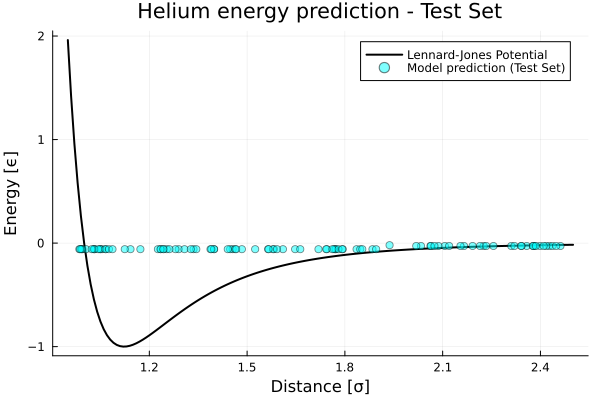

In [47]:
# Denormalize model predictions for the test set using Z-score inversion
test_guess = trained_model(Test_data[1]) .* energy_std .+ energy_mean

# Extract interatomic distances from the test set (for plotting)
test_distances = [Test_data[1][i, 4] for i in 1:size(Test_data[1], 1)]


# Extract true energies from the test set
test_energy = [d[:energy] for d in Test_data[2]]



# Define Lennard-Jones potential curve for reference
r = 0.95:0.01:2.5
lj_energy = 4 .* ((1 ./ r).^12 .- (1 ./ r).^6)

plot(r, lj_energy,
    label="Lennard-Jones Potential",
    color="black",
    lw=2
)

# Plot predictions vs Lennard-Jones potential
scatter!(test_distances, test_guess,
    label="Model prediction (Test Set)",
    alpha=0.5,
    color="cyan"
)



xlabel!("Distance [σ]")
ylabel!("Energy [ϵ]")
title!("Helium energy prediction - Test Set")


In [44]:
model

Chain(
  distance_matrix_layer,
  Parallel(
    vcat,
    Chain(
      var"#427#431"{Int64}(1),
      Chain(
        G1Layer(Float32[1.1498535, 0.854499, 0.945112, 1.6089898, 1.3287859], Float32[3.1056795, 0.80716306, 1.0565473, 3.3618748, 1.3680913], 2.5f0, 2.0f0),  # 10 parameters
        BatchNorm(5),                   # 10 parameters, plus 10
        Dense(5 => 32, tanh),           # 192 parameters
        Dense(32 => 16, tanh),          # 528 parameters
        Dense(16 => 8, tanh),           # 136 parameters
        Dense(8 => 4, tanh),            # 36 parameters
        Dense(4 => 1),                  # 5 parameters
      ),
    ),
    Chain(
      var"#427#431"{Int64}(2),
      Chain(
        G1Layer(Float32[1.1498535, 0.854499, 0.945112, 1.6089898, 1.3287859], Float32[3.1056795, 0.80716306, 1.0565473, 3.3618748, 1.3680913], 2.5f0, 2.0f0),  # 10 parameters
        BatchNorm(5),                   # 10 parameters, plus 10
        Dense(5 => 32, tanh),           # 192 parameters
 

As expected the model managed to reproduce very well the Lennard Jones potential